# Geographical Visualization of Suicides with Python

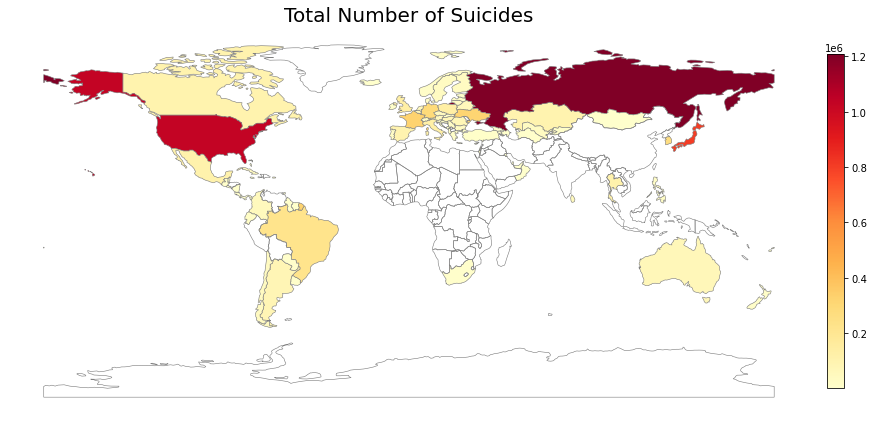

In this notebook we will look into the suicides dataset. Hopefully it can provide us insights in how to take actions based on data and where these actions are most needed.

This data is very sensitive, as these numbers are far more than mere statistics and represent lives that have come to an end. Please be aware of [possible warnings](http://https://www.helpguide.org/articles/suicide-prevention/suicide-prevention.htm) and help those in their time of need.


# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [ ]:
df = pd.read_csv('/kaggle/input/suicide-rates-overview-1985-to-2016/master.csv')
df.info()

# Cleaning
All datasets must be cleaned, this one is no exception.

### Duplicates

In [ ]:
df.duplicated().sum()

### ill named columns

In [ ]:
df.rename(
    columns = {
        'suicides/100k pop' : 'suicide_density',
        'country-year' : 'country_year',
        'HDI for year' : 'year_HDI',
        ' gdp_for_year ($) ': 'gdp_year',
        'gdp_per_capita ($)' : 'gdp_capita'},
    inplace = True)

### Nans

In [ ]:
df.isna().sum()

Many countries only calculate de HDI every now and then (most of then in a 5 year basis), so there is a lot of missing values. Usualy all analysis use the last available number, so all NaNs will be filled with the last available value for the HDI. The code is relatively big and is not really important, so feel free to skip it.

In [ ]:
df['year_HDI'] = df['year_HDI'].fillna(0)

hdi_year_all = {}
for country in df.country.unique():
    hdi_year_all[country] = {}
    for year in sorted(df.year.unique()):
        val = df[(df['country'] == country) & (df.year == year)]['year_HDI'].unique()
        hdi_year_all[country][year] = val[0] if len(val) else 0
        
def hdi_fill(contries = [], years = [], hdi_year_all = {}):
    for contry in contries:
        hdis = [hdi_year_all[contry][year] for year in years]
        
        # Find first non 0 value
        current_hdi = 0
        for h in hdis:
            if h > 0:
                current_hdi = h
                break
            else:
                pass
            
        for i, year in enumerate(years):
            if hdis[i] < current_hdi:
                hdi_year_all[contry][year] = current_hdi
            else:
                current_hdi = hdi_year_all[contry][year] = hdis[i]
            
hdi_fill(df.country.unique(), sorted(df.year.unique()), hdi_year_all)

for country in df.country.unique():
    for year in sorted(df.year.unique()):
        df.loc[(df['country'] == country) & (df['year'] == year), 'year_HDI'] = hdi_year_all[country][year]

In [ ]:
df['year_HDI'].describe()

# Exploratory Data Analysis
This analysis will be focused on the geographical visualization of the data to help us understand where actions are most needed and how the available data relates to the overall number of suicides.


### Categorical features

In [ ]:
df.select_dtypes(include=['object']).columns

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Preliminary analysis raised the problem that some country names don't match between goapandas and our dataset:

In [ ]:
for c in df.country.unique():
    if not c in world.name.tolist():
        print(c)

I'll will fix some imporntant countries by hand, leaving out the smaller ones that can berely be seen in the map

In [ ]:
df.loc[df.country == 'United States', 'country'] = 'United States of America'
df.loc[df.country == 'Russian Federation', 'country'] = 'Russia'
df.loc[df.country == 'Republic of Korea', 'country'] = 'South Korea'
df.loc[df.country == 'Czech Republic', 'country'] = 'Czechia'

#### Total number of suicides

In [ ]:
for country in world.name:
    val = df[df['country'] == country]['suicides_no'].sum()
    world.loc[world.name == country, 'Total occurances'] = val if val else None
    
# An oneliner alternative
# world.loc[world.name == name, 'suicides'] = df.groupby(by='country')['suicides_no'].sum()[name] if name in df.country.unique() else None
fig, ax = plt.subplots(1, figsize=(15,8))

cmap = 'YlOrRd'

ax.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=float(world['Total occurances'].min()),
                                              vmax=float(world['Total occurances'].max())))
sm._A = []
cbar = fig.colorbar(sm,fraction=0.02, pad=0.02)

world.plot(column = 'Total occurances',
           ax = ax,
           cmap = 'YlOrRd',
           linewidth = 0.6,
           edgecolor = 'gray',
           #missing_kwds={
               #"color": "lightgrey",
               #"hatch": "///",
               #"label": "Missing values"
           #},
          )
ax.set_title('Total Number of Suicides', fontsize = 20)
plt.show()

Suicides per 100k citizens of suicides

In [ ]:
for country in world.name:
    val = df[df['country'] == country]['suicide_density'].mean()
    world.loc[world.name == country, 'suicide_density'] = val if val else None
    
# An oneliner alternative
# world.loc[world.name == name, 'suicides'] = df.groupby(by='country')['suicides_no'].sum()[name] if name in df.country.unique() else None
fig, ax = plt.subplots(1, figsize=(15,8))

cmap = 'bone_r'

ax.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=float(world['suicide_density'].min()),
                                              vmax=float(world['suicide_density'].max())))
sm._A = []
cbar = fig.colorbar(sm,fraction=0.02, pad=0.02)

world.plot(column = 'suicide_density',
           ax = ax,
           cmap = cmap,
           linewidth = 0.6,
           edgecolor = 'gray',
           #missing_kwds={
               #"color": "lightgrey",
               #"hatch": "///",
               #"label": "Missing values"
           #},
          )
ax.set_title('Suicides per 100k population', fontsize = 20)
plt.show()

## Gender disparity
Lets see how gender influence the reported number of suicides

In [ ]:
df.groupby(by='sex')['suicides_no'].sum()

The number of male suicides far outweights the females. Lets see how this data is distributed in the world

In [ ]:
country_sex = df.groupby(by=['country', 'sex'])['suicides_no'].sum().reset_index()

for name in world.name:
    try: 
        x = country_sex[(country_sex['sex'] == 'male') & (country_sex.country == name)].suicides_no.values[0] / country_sex[(country_sex.country == name)].sum().suicides_no
    except IndexError:
        x = None
    finally:
        world.loc[world.name == name, 'male_suicides'] = x
        
fig, ax = plt.subplots(1, figsize=(15,8))

cmap = 'Blues'

ax.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=float(world.male_suicides.min()), vmax=float(world.male_suicides.max())))
sm._A = []
cbar = fig.colorbar(sm,fraction=0.02, pad=0.02)

world.plot(column = 'male_suicides',
           ax = ax,
           cmap = cmap,
           linewidth = 0.6,
           edgecolor = 'gray',
          )
ax.set_title('Percentage of suicides commited by males')
plt.show()

There is a country in the middle east (Oman) that has 100% of *reported* suicides commited by males. Other than that we see that in **all** countries males commit more suicides.

## Age group
Lets see how the total number is distributed by age group

In [ ]:
age_df = df.groupby(by=['country', 'age'])['suicides_no'].sum().reset_index()
age_group = {
    "5-14 years" : 1,
    "15-24 years" : 2,
    "25-34 years" : 3,
    "35-54 years" : 4,
    "55-74 years" : 5,
    "75+ years" : 6 }

for name in world.name:
    if name in age_df.country.unique():
        world.loc[world['name'] == name, 'major_age_group'] = age_group[ age_df[age_df.country == name].sort_values(by = 'suicides_no', ascending = False).age.values[0] ]
    else:
        world.loc[world['name'] == name, 'major_age_group'] =  None

In [ ]:
world['major_age_group'].value_counts()

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,12))


minimum = min(age_group.values())
maximum = max(age_group.values()) + 1

cmap = plt.get_cmap('RdBu', maximum - minimum)
ax.axis('off')

world.plot(column = 'major_age_group',
           ax = ax,
           cmap = cmap,
           linewidth = 0.6,
           edgecolor = '#132E32'
          )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = minimum, vmax = maximum))
cax = fig.colorbar(sm, cmap=cmap, ticks=np.arange(minimum- 0.5, maximum),fraction=0.02, pad=0.02)
cax.ax.set_yticklabels([None] + list(age_group.keys()))

plt.show()

The fact that in some countries the majority of suicides is commited by persons with 5-14 years is very distressing, some articles relate this to extreme chronic violence (https://theconversation.com/rising-suicides-in-mexico-expose-the-mental-health-toll-of-living-with-extreme-chronic-violence-99131) and is a problem that must be fought urgently.

In [ ]:
g = sns.countplot(x = 'generation', data = df, order = df['generation'].value_counts().index)
g.set_ylabel('Suicides')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)

plt.show()

The feature 'country_year' is just a combination of two other available columns and does not add any new information

In [ ]:
df.drop(['country_year'], axis = 1, inplace = True)

## Numerical features
'gdp_year' is currently categorical, we must convert it before starting analysing numerical features

In [ ]:
df['gdp_year'] = df['gdp_year'].str.replace(',','').astype(int)

In [ ]:
df.select_dtypes(exclude = ['object']).describe().T

### Time series of global suicides

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].plot(df.groupby(by='year')['suicides_no'].sum(),
        marker = 'o')
ax[0].set_title('Total Suicides per Year')
ax[0].set_ylabel('Total Suicides')
ax[0].set_xlabel('Year')

ax[1].plot(df.groupby(by='year')['suicide_density'].mean(),
        marker = 'o')
ax[1].set_title('Mean of suicides per 100k pops per Year')
ax[1].set_ylabel('Suicides per 100k pop')
ax[1].set_xlabel('Year')

The drop of numbers is 2016 is due to a lack of data, making this years data unfit for any meaningfull analysis. The good news is that the mean number of suicides per 100k pops is in a steady decline globally.

### Cuntry with most cases analysis
Lets take a closer look into the countries with most gross suicides


In [ ]:
country_suicides = df.groupby(by='country')['suicides_no'].sum().reset_index()
most_suicides_country = country_suicides.sort_values('suicides_no', ascending = False).head(5).country.tolist()

year_df = df.groupby(by=['country', 'year']).suicides_no.sum().reset_index()

markers = (m for m in ['o', 'D', 'x', '^', '*'])

fig, ax = plt.subplots(1, figsize = (12,8))
for country in most_suicides_country:
    plt.plot(year_df[year_df.country == country].year,
             year_df[year_df.country == country].suicides_no,
             label = country,
             marker = next(markers)
            )
ax.legend(loc = 1)
plt.show()

Most countries have experienced a recent decline in total numbers, with the exception of the USA, that is in a steady increase. Lets see if this is due to a increase in population or if the situation is indeed becoming worse.

In [ ]:
country_suicides = df.groupby(by='country')['suicides_no'].sum().reset_index()
most_suicides_country = country_suicides.sort_values('suicides_no', ascending = False).head(5).country.tolist()

year_df = df.groupby(by=['country', 'year']).suicide_density.mean().reset_index()

markers = (m for m in ['o', 'D', 'x', '^', '*'])

fig, ax = plt.subplots(1, figsize = (12,8))
for country in most_suicides_country:
    plt.plot(year_df[year_df.country == country].year,
             year_df[year_df.country == country].suicide_density,
             label = country,
             marker = next(markers)
            )
ax.legend(loc = 1)
plt.show()

This shows a worying small but steady increase over the past 10 years in the average number of suicides per 100k pops. In the USA. Russia in the other hand shows a impressive decrese.

To visualize how more countries have evolved this kind of plot becomes very unwieldy, as all curves would be on top of each other. A common way to plot the relative evolution of many countries is by making a scatter plot where one axis is the situation now and the other represents a past date. With this method each country would be represented by a point, not a line.

In [ ]:
N = 15

most_suicides_country = country_suicides.sort_values('suicides_no', ascending = False).head(N).country.tolist()
gdp_suicide = df.groupby(by=['country', 'year']).mean().reset_index()

X = gdp_suicide[(gdp_suicide.country.isin(most_suicides_country)) & (gdp_suicide.year == 2000)].suicide_density.tolist()
Y = gdp_suicide[(gdp_suicide.country.isin(most_suicides_country)) & (gdp_suicide.year == 2012)].suicide_density.tolist()
country_names = gdp_suicide[(gdp_suicide.country.isin(most_suicides_country)) & (gdp_suicide.year == 2012)].country.tolist()
sizes = gdp_suicide[(gdp_suicide.country.isin(most_suicides_country)) & (gdp_suicide.year == 2012)].suicides_no.tolist()
offsets = {
    "Brazil" : (-0.5, 1.5),
    "Canada" : (0.5, -1),
    "France" : (0.8, 0.8),
    "Germany" : (1.0, -1.5),
    "Italy" : (0.2, 1.0),
    "Japan" : (0.5, 2.0),
    "Kazakhstan" : (0.5, 0.5),
    "Mexico" : (0.0, -1.5),
    "Poland" : (0.5, 0.5),
    "Russia" : (0.5, 0.5),
    "South Korea" : (0.5, 0.5),
    "Thailand" : (0.5, 0.5),
    "Ukraine" : (0.5, 0.5),
    "United Kingdom" : (0.5, -0.9),
    "United States of America" : (0.5, 0.5),
}

fig, ax = plt.subplots(1,figsize=(15,10))

for x, y, size, name in list(zip(X, Y, sizes, country_names)):
    if name == 'Thailand':
        continue
    ax.scatter(x, y, s=size, alpha = 0.5)
    ax.plot([5,45],[5,45], ls ='-', color = 'gray')
    ax.annotate(name, (x + offsets[name][0], y + offsets[name][1]), size=13)

ax.set_xlabel('Suicides per 100k in 2000', fontsize = 20)
ax.set_ylabel('Suicides per 100k in 2012', fontsize = 20)
    
plt.show()

In [ ]:
Poins below the gray line represent a relative decrease in suicides per 100k pops.

Turning our attention now to gdp, we can take a look into its correlation with the number of suicides.

In [ ]:
sns.heatmap(df.groupby(by=['country', 'year']).mean().corr(), annot = True)
plt.show()

A few interesting things stand out. The negative correlation between HID and total number of suicides is to be expected, as an increce in human conditions sould equate to a reduction in suicides, but a interesting thing that the same rationale cannot be applied to the gdp. The data don't support the affirmation that an increace in per capita gdp decreases the chance of suicide!

Such analysis should be taken with a grain of salt (acctually with a lot more than just a grain), beacause we are mixing many countries with fundamental social economical differences that could not be analysied toghether. This is but a quick and severely incomplete 'global tendency' analysis.

In [ ]:
df.describe().T

# Simple model analysis
I will not make any fancy analysis for each country this time. Lets just make a linear regression on the past few years in each country to see if the situation is getting better or worst recently. A full time analysis could be done, but the information it provides is dubious, as many radically different hitorical moments would be encompassed by the same analysis.

In [ ]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b

country_year = df.groupby(by=['country', 'year']).mean().reset_index()
def determineBehavior(recent_behavior = {}, start_year = 2000, verbose = True):
    for country in df.country.unique():
        recent_behavior[country] = {}
        total_suicides = []
        years = []

        for year in range(start_year, 2015):
            suicides = country_year[(country_year.country == country) & (country_year.year == year)].suicide_density
            if len(suicides) > 0:
                if suicides.values[0] > 0:
                    total_suicides.append(suicides.values[0])
                    years.append(year)

        if len(total_suicides) < 2:
            if verbose:
                print(f"{country} without data about suicides_no")
            recent_behavior.pop(country, None)
        else:
            try:
                popt, pcov = curve_fit(func, years, total_suicides)
                recent_behavior[country]['slope'] = popt[0]
                recent_behavior[country]['historic'] = total_suicides
                recent_behavior[country]['years'] = years
            except:
                print(f'could not make reg for {country}')

In [ ]:
# adapted from :http://chris35wills.github.io/matplotlib_diverging_colorbar/

import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


In [ ]:
recent_behavior = {}
determineBehavior(recent_behavior, 2005, verbose = False)

for name in world.name:
    if name in recent_behavior.keys():
        world.loc[world.name == name, 'recent_tendency'] = recent_behavior[name]['slope']
    else:
        world.loc[world.name == name, 'recent_tendency'] = None

fig, ax = plt.subplots(1, figsize=(15,8))

cmap = 'coolwarm'
ax.axis('off')
elev_min=float(world.recent_tendency.min())
elev_max=float(world.recent_tendency.max())
mid_val=0

sm = plt.cm.ScalarMappable(cmap=cmap, norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
sm._A = []
cbar = fig.colorbar(sm,fraction=0.02, pad=0.02)

world.plot(column = 'recent_tendency',
           ax = ax,
           cmap = cmap,
           norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max),
           linewidth = 0.6,
           edgecolor = 'gray'
          )


plt.show()

# Closing notes

Remember that suicide and depression are real, serious problems that should be delt with by trained professionals. If you know someone that is in need of help please inform yourself about how can you can make a educated action and possibly help to save a life.

Thanks for reading it all! If you like this analysis (or not), let me know as it really does help to improve. 
<hr>
